## GARCH Models

$\mathrm{ARCH}$모형은 매우 간단하였지만, 추정해야 할 계수가 늘어난다는 단점 때문에 점차 더욱 간단한 모형에 대한 요구가 늘어나기 시작하였다. Boller slev는 $\mathrm{ARCH}$모형을 일반화한 Generalized ARCH ($\mathrm{GARCH}$)모형을 제안하였는데, 변동성에 대한 ARMA모형을 추정한 것과 유사한 형태이다. 변동성을 두개의 설명변수를 통해 추정하였기에 추정해야 할 parameter가 대폭 감소하는 장점이 있다

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

start_date = '2018-01-01'
data = yf.download(
    '^GSPC',
    start = start_date,
    interval = '1wk',
    progress = False
)

YF.download() has changed argument auto_adjust default to True


In [2]:
ret = data['Close'].pct_change().dropna()
ret.head()

Ticker,^GSPC
Date,
2018-01-08,0.015708
2018-01-15,0.008635
2018-01-22,0.022265
2018-01-29,-0.038547
2018-02-05,-0.051620


### 1. Generalized Auto Regressive Conditional Heteroscedasticity

$a_t$가 $\mathrm{GARCH}(m,s)$모형을 따를 경우 다음과 같이 나타낼 수 있다

$$a_t = \sigma_t \epsilon_t, ~~~~~ \sigma_t^2 = \alpha_0 + \sum_{i=1}^m \alpha_i a_{t-1}^2 + \sum_{j=1}^s \beta_j \sigma_{t-j}^2$$

$\eta_t = a_t^2 - \sigma_t^2$라고 가정하면 $\mathrm{GARCH}$ 모형은 다음과 같이 표현 가능하다

$$a_t^2 = \alpha_0 + \sum_{i=1}^{\max (m,s)} (\alpha_i + \beta_i) a_{i-1}^2 + \eta_t - \sum_{j=1}^s \beta_j \eta_{t-j}$$

여기서 $\eta_t$는 martingale difference Series, iid sequence로써 다음과 같은 성질을 가진다
$$E(\eta_t) = 0$$
$$\mathrm{Cov}(\eta_t, \eta_{t-j}) = 0 ~~~ \mathrm{for} ~~ j \geq 1$$

$\text{ARMA}$모형에서와 같이 $a_t^2$의 기대값을 다음과 같이 추정 가능하다

$$E(a_t^2) = \frac{\alpha_0}{1 - \Sigma_{i=1}^{\max (m,s)}(\alpha_i + \beta_i)}$$

$\mathrm{GARCH}(1,1)$모형의 경우

$$a_t^2 = \alpha_0 + \alpha_1 a_{t-1}^2 + \beta_1 \sigma_{t-1}^2, ~~~~~ 0 \leq \alpha_1, \beta_1 \leq 1, (\alpha_1 + \beta_1) < 1$$

이다. 여기서 제약조건은 변동성이 **발산하지 않는다**로 해석할 수 있다

#### example 1

S&P500 지수에 대해 2018년 1월 1일부터의 $\mathrm{GARCH}$ 모형을 추정하라. 추정된 모형을 가지고 적절한 방법으로 시각화하라

- $\mathrm{GARCH}$ 모형의 차수를 정하는 것은 쉽지 않다. 다만, 대부분의 경우 order가 (1,1), (1,2), (2,1)이기 때문에, 세 모형을 모두 추정 후 비교하여 선정하는 방식을 택한다

$\mathrm{GARCH}(1,1)$인 경우

In [3]:
import arch 
import warnings
warnings.filterwarnings('ignore')

garch_model1 = arch.arch_model(
    ret, vol = 'GARCH', 
    p = 1, q = 1
)
result1 = garch_model1.fit()
print(result1.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 5.408141747689648e+17
Iteration:      2,   Func. Count:     17,   Neg. LLF: 127943.23319484257
Iteration:      3,   Func. Count:     26,   Neg. LLF: 1502148451676.2617
Iteration:      4,   Func. Count:     35,   Neg. LLF: 5579751.106214564
Iteration:      5,   Func. Count:     46,   Neg. LLF: -889.0019174707778
Optimization terminated successfully    (Exit mode 0)
            Current function value: -889.001918508786
            Iterations: 9
            Function evaluations: 46
            Gradient evaluations: 5
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                889.002
Distribution:                  Normal   AIC:                          -1770.00
Method:            Maximum Like

$\mathrm{GARCH}(1,2)$인 경우

In [4]:
garch_model2 = arch.arch_model(
    ret, vol = 'GARCH', 
    p = 1, q = 2
)
result2 = garch_model2.fit()
print(result2.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 77307387.11220813
Iteration:      2,   Func. Count:     19,   Neg. LLF: 5.399957429123782e+16
Iteration:      3,   Func. Count:     31,   Neg. LLF: 10507919320828.588
Iteration:      4,   Func. Count:     42,   Neg. LLF: -885.2055843554697
Optimization terminated successfully    (Exit mode 0)
            Current function value: -885.2055857203512
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 4
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                885.206
Distribution:                  Normal   AIC:                          -1760.41
Method:            Maximum Likelihood   BIC:                          -1740.80
                        

$\mathrm{GARCH}(2,1)$인 경우

In [5]:
garch_model3 = arch.arch_model(
    ret, vol = 'GARCH', 
    p = 2, q = 1
)
result3 = garch_model3.fit()
print(result3.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 55576016.22634547
Iteration:      2,   Func. Count:     19,   Neg. LLF: 9834371.701054221
Iteration:      3,   Func. Count:     31,   Neg. LLF: 13867.75998230067
Iteration:      4,   Func. Count:     42,   Neg. LLF: -886.840029907692
Optimization terminated successfully    (Exit mode 0)
            Current function value: -886.8400308864589
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 4
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                886.840
Distribution:                  Normal   AIC:                          -1763.68
Method:            Maximum Likelihood   BIC:                          -1744.07
                              

종합적으로 고려해 봤을 때, $\mathrm{GARCH}(1,2)$인 경우가 가장 성능이 좋으므로, 최종 모델을 다음과 같이 추정한다

$$r_t = 0.00345 + a_t$$
$$a_t = \sigma_t \epsilon_t$$
$$\sigma_t^2 = 0.00007 + 0.2 a_{t-1}^2  - 0.35 σ_{t-1}^2 - 0.35 σ_{t-2}^2$$

추정된 변동성은 `conditional_volatility` 속성을 사용하여 plotting 가능하다

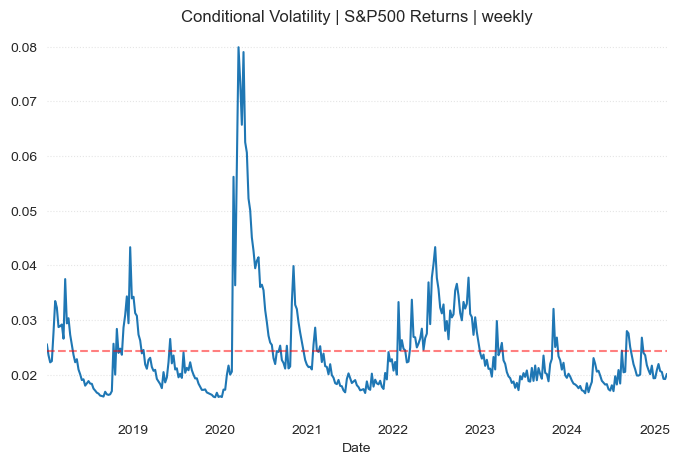

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 5))
result2.conditional_volatility.plot(ax = ax)
plt.axhline(
    result2.conditional_volatility.mean(),
    color = 'red', 
    linestyle = '--', 
    alpha = 0.5
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls=':', alpha=0.5)
plt.title(r'Conditional Volatility | S&P500 Returns | weekly')
plt.show()

#### Exercise 1.

S&P500과 KOSPI 중 어느 시장이 더 리스크가 큰지 예상하라. 2018년 1월부터의 KOSPI data를 import하라. 적절한 GARCH모형을 추정하고 시각화하라. S&P500과 KOSPI중 변동성(리스크)이 큰 시장은 어디인가? 예상한 결과와 같은가?

In [ ]:
# Write your code here!

### 2. GJR-GARCH

GJR-GARCH 모델은 수익률 분포의 비대칭성을 반영한다는 특성을 가지고 있다. 이는 나쁜 소식이 좋은 소식보다 더 큰 파급력을 미치는 현상을 잘 모델링한다. 모델의 방정식은 다음과 같은 형태를 가진다.

$$ \sigma_t^2=w+\sum_{k=1}^q(\alpha_k r^2_{t-k}+\gamma r^2_{t-k}I_{t-k}(\epsilon_{t-k}<0))+\sum_{k=1}^p \beta_k \sigma_{t-k}^2$$

여기서 $\sigma_t^2$는 시점 t에서의 조건부 분산 (조건부 변동성), $w$는 상수항, $\alpha_k$는 $r_{t-k}^2$의 계수 (과거 수익률 제곱의 계수)이며, $\gamma$는 비대칭성을 나타내는 계수를 의미한다. $\epsilon_{t-k}$가 음수일 때 추가적인 효과를 반영하기 위해 사용되며, $I_{t-k}(\epsilon_{t-k} < 0)$는 지시 함수로, $\epsilon_{t-k}$가 음수일 때 1, 그렇지 않으면 0으로 판단한다. 일종의 가변수로 생각하면 좋다. $\beta_k$는 $\sigma_{t-k}^2$의 계수 (과거 분산의 계수)이다. $\gamma$를 다음과 같이 지정함에 따라, 상황에 따른 모델링이 가능하다.

- $\gamma=0$ : 과거 충격에 대한 반응은 긍정과 부정이 동일하다.

- $\gamma>0$ : 과거 부정적인 충격에 대한 반응이 긍정적인 충격에 대한 반응보다 더 강력하다

- $\gamma<0$ : 과거 긍정적인 충격에 대한 반응이 부정적인 충격에 대한 반응보다 더 강력하다

#### Stationarity Condition

모델이 성립하기 위해서는 조건부 이분산이 **가역성(stationarity)** 을 만족해야 한다. 가역 조건을 만족하지 않으면, 모델에서 추정한 분산이 시간이 지남에 따라 무한히 커질 수 있어 현실적인 변동성 추정이 불가능하다. $\text{GJR-GARCH}$ 모델에서 가역 조건을 만족하기 위해서는 다음 조건을 만족해야 한다

$$w > 0, \alpha_k >= 0, \gamma >= 0, \beta_k >= 0 ~~~~ \forall k$$

또한, 아래의 불평등이 성립해야 한다

$$\sum_{k=1}^q (\alpha_k + 0.5\gamma) + \sum_{k=1}^p \beta_k < 1$$

위 식은 $\text{GARCH}$ 모델의 경우와 유사하나, $0.5\gamma$ 항목이 추가된 점에서 $\text{GJR-GARCH}$ 모델의 특성을 반영한다. 이는 부정적인 충격의 영향을 포함한 가역 조건이다. 조건을 만족하면 분산은 시간이 지남에 따라 일정한 평균값을 가지게 된다.

In [7]:
gjr_garch = arch.arch_model(
    ret,
    vol = 'GARCH',
    p = 1,
    o = 1,
    q = 1,
)

In [8]:
res_gjr = gjr_garch.fit()

Iteration:      1,   Func. Count:      7,   Neg. LLF: 668967704.9981611
Iteration:      2,   Func. Count:     19,   Neg. LLF: -897.7963837291463
Optimization terminated successfully    (Exit mode 0)
            Current function value: -897.7963838823159
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2


In [9]:
print(res_gjr.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                897.796
Distribution:                  Normal   AIC:                          -1785.59
Method:            Maximum Likelihood   BIC:                          -1765.98
                                        No. Observations:                  373
Date:                Sun, Mar 02 2025   Df Residuals:                      372
Time:                        02:44:58   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         3.3361e-03  1.418e-03      2.352  1.865e-02 [5.

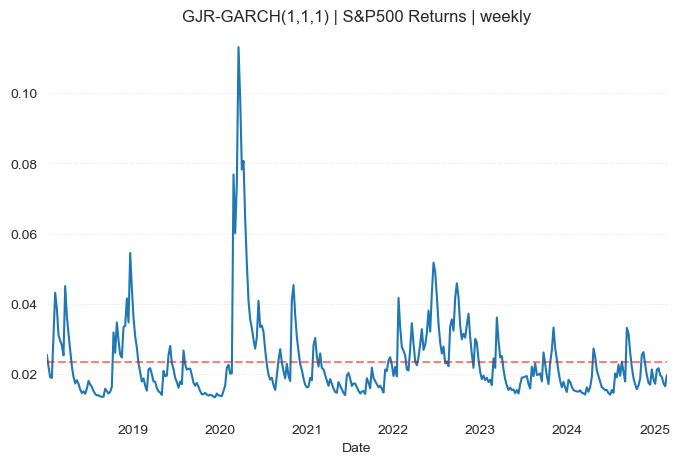

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))
res_gjr.conditional_volatility.plot(ax = ax)
plt.axhline(
    res_gjr.conditional_volatility.mean(),
    color = 'red', 
    linestyle = '--', 
    alpha = 0.5
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls=':', alpha=0.5)
plt.title(r'GJR-GARCH(1,1,1) | S&P500 Returns | weekly')
plt.show()

### 3. Exponential GARCH Model

EGARCH(Exponential Generalized Autoregressive Conditional Heteroskedasticity) 모델은 변동성의 비대칭 효과를 효과적으로 모델링하기 위해 설계된 모델이다. 특히, $\text{EGARCH}$는 로그 형식으로 지정되어 있어 변동성이 음수가 되는 것을 방지할 수 있는 추가적인 제약이 필요 없다는 장점을 가진다. 이는 $\text{GARCH}$ 모델과 달리 변동성을 로그로 취급함으로써 안정적인 변동성 추정을 가능하게 한다.

$$\log(\sigma_t^2)=w+\sum_{k=1}^p \beta_k \log(\sigma_{t-k}^2)+\sum_{k=1}^q \alpha_k \frac{\vert r_{t-k} \vert}{\sqrt {\sigma_{t-k}^2}} + \sum_{k=1}^q \gamma_k \frac{r_{t-k}}{\sqrt{\sigma_{t-k}^2}}$$

where

- $\sigma_t^2$ : 시점 $t$에서의 조건부 분산 (조건부 변동성)
- $w$ : 상수항, 모델의 평균 수준
- $\beta_k$: 이전 시점의 로그 조건부 분산에 대한 계수
- $\alpha_k$: 이전 시점의 절대 수익률에 대한 계수
- $\gamma_k$: 이전 시점의 수익률에 대한 계수 (비대칭 효과를 모델링)
- $r_{t-k}$: 시점 $t-k$의 수익률
- $I_{t-k}(\epsilon_{t-k} < 0)$: 지시 함수로, $\epsilon_{t-k}$가 음수일 때 1, 그렇지 않으면 0 ($\text{EGARCH}$에서는 로그 형식을 사용하여 별도의 지시 함수가 필요 없다)

EGARCH 모델은 변동성의 비대칭성을 반영하기 위해 설계되었으며, 특히 금융 시장에서 흔히 관찰되는 레버리지 효과를 설명할 수 있다. $\text{EGARCH}$ 모델은 이러한 비대칭성을 $\gamma_k$ 계수를 통해 효과적으로 모델링한다.

#### Stationarity Condition

여기서 $\text{EGARCH}$ 모델이 성립하기 위해서는 모델이 **가역성(stationarity)** 을 만족해야 한다. 이는 시계열 데이터의 분산이 시간이 지남에 따라 일정한 평균과 분산을 유지하는 것을 의미한다. $\text{EGARCH}$ 모델의 가역 조건은 다음과 같다

$$\sum_{k=1}^p (\beta_k) + \sum_{k=1}^q (\alpha_k + |\gamma_k|) < 1$$

이 조건은 모델의 전체적인 반응도가 1보다 작아야 함을 의미하며, 이를 통해 분산이 안정적으로 유지될 수 있다. 즉, 각 계수의 합이 1보다 작아야 분산이 시간이 지남에 따라 수렴하게 된다.

$$\sigma_t^2 = E[(r_t - \mu)^2 | F_{t-1}]$$

여기서 $F_{t-1}$은 시점 $t-1$까지의 정보 집합을 의미한다. 이는 현재의 분산이 과거 정보에 의존함을 나타낸다.

$$\log(\sigma_t^2) = w + \sum_{k=1}^p \beta_k\log(\sigma_{t-k}^2) + \sum_{k=1}^q \alpha_k \frac{|r_{t-k}|}{\sqrt{\sigma_{t-k}^2}} + \sum_{k=1}^q \frac{\gamma_k r_{t-k}}{\sqrt{\sigma_{t-k}^2}}$$

위 식은 로그 조건부 분산이 과거의 로그 조건부 분산, 절대 수익률, 그리고 수익률의 비대칭 효과에 의해 결정됨을 나타낸다.

비대칭성의 영향은 $\gamma_k$ 계수가 양수일 경우, 수익률이 음수일 때 $\log$ 형식에서는 절대값을 사용하지 않기 때문에 직접적인 비대칭 효과는 없지만, $\gamma_k$가 양수이면 수익률이 높을수록 조건부 분산에 더 큰 영향을 미친다. 반대로, $\gamma_k$가 음수일 경우, 수익률이 낮을수록 조건부 분산에 더 큰 영향을 미친다. 만약 가역 조건이 만족된다면, $\text{EGARCH}$ 모델에서 추정된 조건부 분산 $\sigma_t^2$는 과거 수익률과 분산을 기준으로 안정적으로 변화하며, 특정 수준에서 유지된다. 이는 변동성을 모델링하고 예측하는 데 있어서 현실적인 결과를 제공한다.

In [11]:
egarch = arch.arch_model(
    ret,
    vol = 'EGARCH',
    p = 1,
    o = 1,
    q = 2,
)

In [12]:
res_egarch = egarch.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 7.025327774879906e+16
Iteration:      2,   Func. Count:     21,   Neg. LLF: 193985894795.1496
Iteration:      3,   Func. Count:     31,   Neg. LLF: 921479924.7069606
Iteration:      4,   Func. Count:     40,   Neg. LLF: 386821498.37908137
Iteration:      5,   Func. Count:     50,   Neg. LLF: -461.7144089102487
Iteration:      6,   Func. Count:     58,   Neg. LLF: -742.2246466737051
Iteration:      7,   Func. Count:     66,   Neg. LLF: -905.5451334595407
Iteration:      8,   Func. Count:     73,   Neg. LLF: -881.1390042230046
Iteration:      9,   Func. Count:     81,   Neg. LLF: -905.0938060519993
Iteration:     10,   Func. Count:     89,   Neg. LLF: -906.4667972987447
Iteration:     11,   Func. Count:     96,   Neg. LLF: -906.5582053871224
Iteration:     12,   Func. Count:    103,   Neg. LLF: -906.5806585713653
Iteration:     13,   Func. Count:    110,   Neg. LLF: -906.5920463346175
Iteration:     14,   Func. Count:    117,   Neg. L

In [13]:
print(res_egarch.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                906.594
Distribution:                  Normal   AIC:                          -1801.19
Method:            Maximum Likelihood   BIC:                          -1777.66
                                        No. Observations:                  373
Date:                Sun, Mar 02 2025   Df Residuals:                      372
Time:                        02:45:07   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         2.0690e-03  8.976e-04      2.305  2.116e-02 [3.

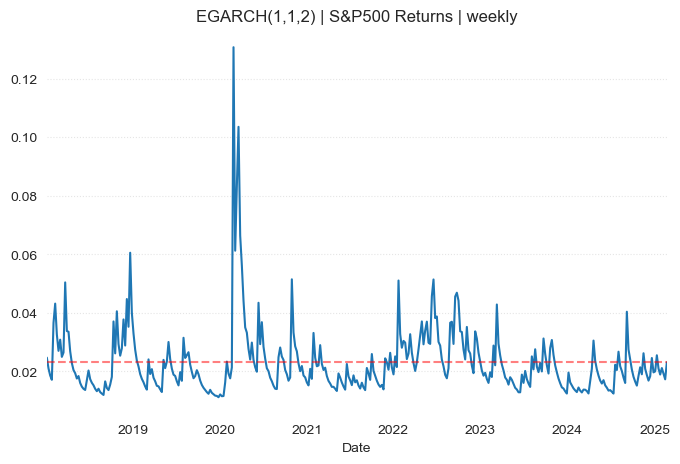

In [14]:
fig, ax = plt.subplots(figsize=(8, 5))
res_egarch.conditional_volatility.plot(ax = ax)
plt.axhline(
    res_egarch.conditional_volatility.mean(),
    color = 'red', 
    linestyle = '--', 
    alpha = 0.5
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls=':', alpha=0.5)
plt.title(r'EGARCH(1,1,2) | S&P500 Returns | weekly')
plt.show()